# Treinamento de uma CNN no CIFAR 10

**Nome: Orlem Lima dos Santos**


O objetivo deste exercício é implementar e treinar uma rede convolucional que obtenha a maior acurácia no dataset de teste do CIFAR 10.

Podem definir sua própria rede ou utilizar redes pré-treinadas, como a Resnet.

# Metodologia usada

O modelo usado é uma **EfficientNetB7 (com advprop)** que foi treinada em duas etapas devido a limitação de horas do colab. 

No primeiro notebook 

https://colab.research.google.com/drive/1E7xU9Q5YOqKqIVy2sAMhbWRVYU6Za4jT?usp=sharing

https://app.neptune.ai/orllem/Aula6CIFAR/e/AUL2-64

é obtido um F1 de **98.19%** em 20 eṕocas.

Depois aproveitando o checkpoint é treinado por mais 5 épocas obtendo um F1 de **98.31%**


![](https://drive.google.com/uc?export=view&id=1YhR8wiCIFeiYbqF5Gy-JvSCtU3OrLgiI)


São utilizados também 



1.   label smoothing ($\alpha=0.1$)
label smoothing substitui o vetor de rótulo codificado one-hot y_hot por uma mistura de y_hot e a distribuição uniforme:

$$y = (1 - \alpha)\times y_{hot} +  \alpha/K$$

Lidando assim com erros de rotulação

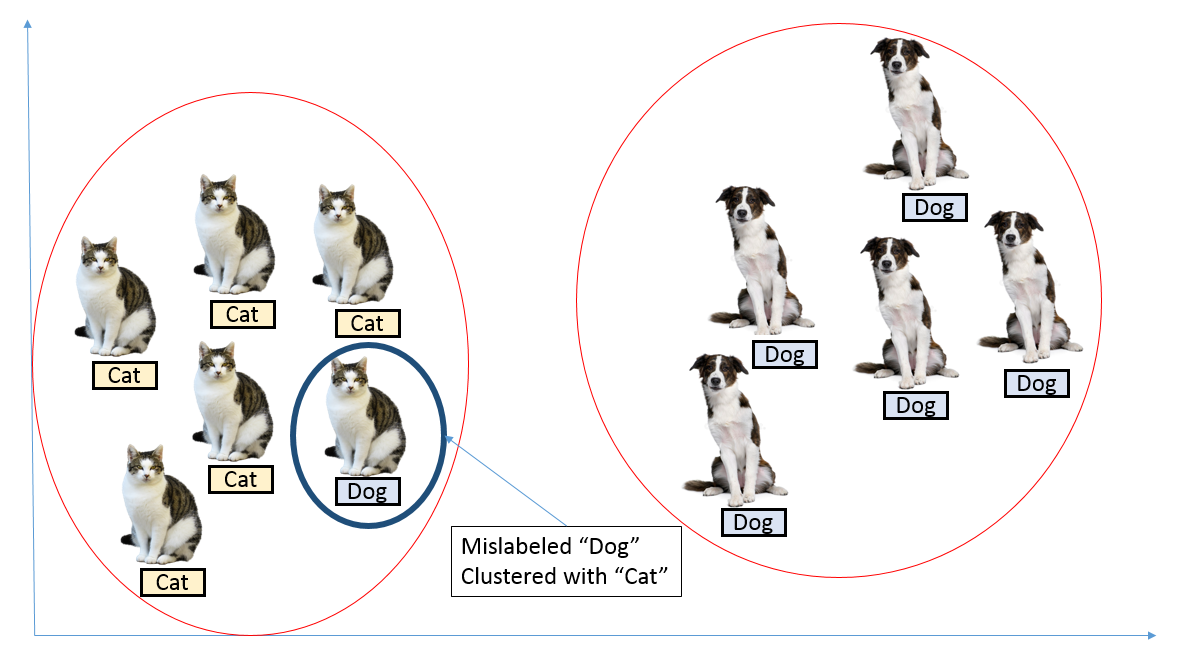

2.   lr_scheduler  chamado **CosineAnnealingLR**

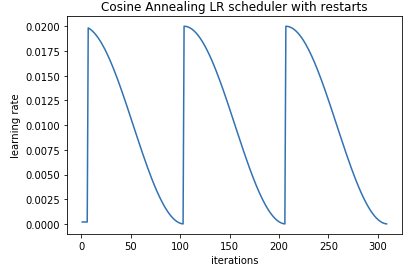




## Inicialização dos parâmetros

In [ ]:
version = "effnetB7_cifar10_resized_sgd_parte2_test8" #@param {type: "string"}
lr = 1e-5#@param {type: "number"}
lr_final = 1e-8#@param {type: "number"}
w_decay = 0#@param {type: "number"}
bs = 16#@param {type: "integer"}
accum_grads = 4#@param {type: "integer"}
patience = 3#@param {type: "integer"}
max_epochs = 5#@param {type: "integer"}
drop_rate_effnet = 0.5#@param {type: "number"}
drop_connect_rate_effnet = 0.5#@param {type: "number"}
freeze_BN = True#@param {type: "boolean"}
freeze = False#@param {type: "boolean"}

# Define hyperparameters
hparams = {"version": version,
          "lr": lr,
          "lr_final": lr_final,
          "w_decay": w_decay,
          "bs": bs,
          "drop_rate_effnet": drop_rate_effnet,
          "drop_connect_rate_effnet": drop_connect_rate_effnet,
          "patience": patience,
          "accum_grads": accum_grads,
          "max_epochs": max_epochs,
          "freeze_BN": freeze_BN,
          "freeze": freeze,}
hparams

{'accum_grads': 4,
 'bs': 16,
 'drop_connect_rate_effnet': 0.5,
 'drop_rate_effnet': 0.5,
 'freeze': False,
 'freeze_BN': True,
 'lr': 1e-05,
 'lr_final': 1e-08,
 'max_epochs': 5,
 'patience': 3,
 'version': 'effnetB7_cifar10_resized_sgd_parte2_test8',
 'w_decay': 0}

## Inicializando o Neptune

In [ ]:
# !pip install neptune-client
# !pip install efficientnet_pytorch
# !pip install pytorch_lightning

In [ ]:
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [ ]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMmJkZTg1Yy1kMjQ1LTRmMjEtYjBmYy1kMjVlMmMxODcyMTgifQ==",
    project_name='orllem/Aula6CIFAR')

NeptuneLogger will work in online mode


## Importação das bibliotecas

In [ ]:
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from google.colab import drive

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.metrics.functional import f1

from efficientnet_pytorch import EfficientNet
import nvidia_smi

In [ ]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

Pytorch Lightning Version: 1.2.10
Device name: b'Tesla P100-PCIE-16GB'


## Download do Dataset

In [ ]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize((224, 224)), 
     torchvision.transforms.Lambda(lambda img: img*2.0 - 1.0)])            

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)



mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Dataset e dataloader

In [ ]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print(len(train_dataset))
print(len(val_dataset))

40000
10000


In [ ]:
batch_size = hparams['bs']
print(batch_size)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

print(train_dataloader.dataset.dataset)

x_train, y_train = next(iter(train_dataloader))

print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

16
Número de minibatches de trenamento: 2500
Número de minibatches de validação: 625
Número de minibatches de teste: 625
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear)
               Lambda()
           )

Dimensões dos dados de um minibatch: torch.Size([16, 3, 224, 224])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Definindo o Modelo

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        print('freezing ', m)
        m.eval()

In [ ]:
class ModelEffnet(nn.Module):
    def __init__(self):
        super(ModelEffnet, self).__init__()

        override_params = {'dropout_rate':hparams['drop_rate_effnet'],
                           'drop_connect_rate':hparams['drop_connect_rate_effnet']}
        
        self.feature_extraction = EfficientNet.from_pretrained('efficientnet-b7', advprop=True, **override_params)

        # freeze BN
        if hparams['freeze_BN']:
          self.feature_extraction = self.feature_extraction.apply(set_bn_eval)

        if hparams['freeze']:
          print('freezing Effnet')
          for param in self.feature_extraction.parameters():
            param.requires_grad = False

        self.dense = torch.nn.Sequential(
            # one layers at output
            nn.Dropout(p=0.1),
            nn.Linear(125440, 10),
        )
    
    def forward(self, x):
      # print('x', x.shape)
      features = self.feature_extraction.extract_features(x)
      features = features.reshape((features.shape[0],-1))
      # print('features', features.shape)
      return self.dense(features)

In [ ]:
print(ModelEffnet())

Loaded pretrained weights for efficientnet-b7
freezing  BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_sta

## Criação do modelo Pytorch Lightning

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

In [ ]:
criterion = LabelSmoothingCrossEntropy()

In [ ]:
class EffnetClassifier(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.hparams = hparams

        # Note como a arquitetura esta dependente dos hiperparâmetros salvos.
        self.model = ModelEffnet()

    def forward(self, x):
        logits = self.model(x)
        return logits

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
  
        # predict 
        logits = self(x)

        # loss cross-entropy compute
        cross_loss = criterion(logits, y)

        self.log('cross_loss_step', cross_loss, prog_bar=True)
        
        return cross_loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()       

        self.log("train_loss", loss, prog_bar=True)
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        # predict 
        logits = self(x)
        preds = torch.argmax(logits, dim=1)

        val_cross_loss = criterion(logits, y)
        val_acc = accuracy(preds, y)
        val_f1 = accuracy(preds, y)

        self.log('val_loss_step', val_cross_loss, prog_bar=True)
        self.log('val_acc_step', val_acc, prog_bar=True)
        self.log('val_f1_step', val_f1, prog_bar=True)

        return {"val_loss_step": val_cross_loss, "val_acc_step": val_acc,  
                "val_f1_step": val_f1}

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x['val_loss_step'] for x in outputs]).mean()
        val_acc = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        val_f1 = torch.stack([x['val_f1_step'] for x in outputs]).mean()

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        self.log("val_f1", val_f1, prog_bar=True)
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        
        # predict 
        logits = self(x)
        preds = torch.argmax(logits, dim=1)

        cross_loss = criterion(logits, y)

        acc = accuracy(preds, y)
        f1 = accuracy(preds, y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {"test_loss_step": cross_loss, "test_acc_step": acc, 
                "test_f1_step": f1}

    def test_epoch_end(self, outputs):
        loss = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        acc = torch.stack([x['test_acc_step'] for x in outputs]).mean()
        f1 = torch.stack([x['test_f1_step'] for x in outputs]).mean()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            nesterov=False,
            momentum=0.9,
            weight_decay=self.hparams.w_decay,
        )
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                self.hparams.max_epochs,
                eta_min=self.hparams.lr_final  # total epochs to run
            )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_f1'}

## Treinamento

In [ ]:
import os

In [ ]:
load_model_best = '/content/drive/My Drive/aula6_checkpoints_AP/effnetB7_cifar10_resized_sgd_test2-epoch=17-step=11249.ckpt'
pl_model = EffnetClassifier(hparams).load_from_checkpoint(load_model_best, params=hparams)

checkpoint_path = 'drive/My Drive/aula6_checkpoints_AP/epoch=0.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')
checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                    dirpath=checkpoint_dir,
                                                    save_top_k=1, 
                                                    monitor="val_f1", mode="max")
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_f1', patience=hparams["patience"], mode='max')
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(gpus=1, 
                     logger=neptune_logger,
                     precision=16,
                     accumulate_grad_batches=hparams["accum_grads"],
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback, lr_monitor],
                     max_epochs=hparams["max_epochs"])

Loaded pretrained weights for efficientnet-b7
freezing  BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_sta

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory /content/drive/My Drive/aula6_checkpoints_AP exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


Files in /content/drive/My Drive/aula6_checkpoints_AP: ['resnet_cifar10_simCLR-epoch=4-step=3124.ckpt', 'resnet_cifar10_simCLR-epoch=3-step=2499.ckpt', 'resnet_cifar10_simCLR-epoch=1-step=1249.ckpt', 'resnet_cifar10_simCLR-epoch=2-step=1874.ckpt', 'resnet_cifar10_simCLR-epoch=19-step=12499.ckpt', 'effnet_cifar10_simCLR-epoch=24-step=15624.ckpt', 'effnetB1_cifar10_simCLR-epoch=3-step=2499.ckpt', 'effnetB1_cifar10_simCLR-epoch=1-step=1249.ckpt', 'effnetB1_cifar10_simCLR_test1-epoch=15-step=9999.ckpt', 'effnetB1_cifar10_simCLR_test2-epoch=48-step=30624.ckpt', 'effnetB1_cifar10_simCLR_test3-epoch=64-step=40624.ckpt', 'effnetB1_cifar10_simCLR_test4-epoch=59-step=37499.ckpt', 'effnetB1_cifar10_simCLR_test4-epoch=42-step=26874.ckpt', 'effnetB1_cifar10_simCLR_test5-epoch=4-step=784.ckpt', 'effnetB1_cifar10_simCLR_test5-epoch=91-step=57499.ckpt', 'effnetB1_cifar10_simCLR_test5-epoch=58-step=36874.ckpt', 'effnetB1_cifar10_simCLR_test6-epoch=1-step=1249.ckpt', 'effnetB1_cifar10_simCLR_test6-epoch

In [ ]:
trainer.fit(pl_model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://app.neptune.ai/orllem/Aula6CIFAR/e/AUL2-92



  | Name  | Type        | Params
--------------------------------------
0 | model | ModelEffnet | 67.6 M
--------------------------------------
67.6 M    Trainable params
0         Non-trainable params
67.6 M    Total params
270.409   Total estimated model params size (MB)


1

## Teste

In [ ]:
best_model = checkpoint_callback.best_model_path
print(best_model)
test_model = EffnetClassifier(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

/content/drive/My Drive/aula6_checkpoints_AP/effnetB7_cifar10_resized_sgd_parte2_test8-epoch=4-step=3124.ckpt
Loaded pretrained weights for efficientnet-b7
freezing  BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_

In [ ]:
trainer.test(test_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9967999458312988,
 'test_f1': 0.9967999458312988,
 'test_loss': 0.5368426442146301}
--------------------------------------------------------------------------------


[{'test_acc': 0.9967999458312988,
  'test_f1': 0.9967999458312988,
  'test_loss': 0.5368426442146301}]

In [ ]:
trainer.test(test_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9830999970436096,
 'test_f1': 0.9830999970436096,
 'test_loss': 0.5741431713104248}
--------------------------------------------------------------------------------


[{'test_acc': 0.9830999970436096,
  'test_f1': 0.9830999970436096,
  'test_loss': 0.5741431713104248}]